In [1]:
import h5py
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np

import sys 

sys.path.insert(0,'..')
import jabble.dataset
import jabble.loss
import jabble.model

import pickle

In [2]:
print(jabble.dataset.velocityfromshift(9e-3)/const.c)

0.00899975700787291


<h1>Intro to Jabble: Fitting EPRVs from Simulacra</h1>
This notebook will give you an introduction to how jabble work by fitting to a dataset generate by Simulacra. Where the EPRVs are precisely known and can be checked for accuracy

In [3]:
import astropy.io.fits

In [4]:
data    = astropy.io.fits.open('../data/2M12504515+1133371.fits')
# epoches = data['data']['flux'].shape[0]

In [5]:
data[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =               104456 / length of dimension 1                          
NAXIS2  =                   52 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
TTYPE1  = 'wavelength'                                                          
TFORM1  = '6144D   '                                                            
TDIM1   = '(6144)  '                                                            
TTYPE2  = 'flux    '                                                            
TFORM2  = '6144E   '        

In [6]:
flux = np.array(data[1].data['flux'])
ferr = np.array(data[1].data['flux_err'])
wave = np.array(data[1].data['wavelength']) * u.Angstrom
mask = np.array(data[1].data['mask'])

<h2>Jabble Dataset</h2>
Initialize the jabble dataset here using the keys from the h5 file. And we are going to assume none of the data needs to be masked. That will likely change in the future.

In [7]:
import scipy.ndimage
def normalize(flux,sigma):
    return scipy.ndimage.gaussian_filter(flux,sigma=sigma)

In [8]:
wave.shape

(52, 6144)

In [9]:
sigma = 80
wob_data = jabble.dataset.WobbleDataset(wave,flux,ferr,mask,normalize,nargs=[sigma])

/home/mdd423/wobble_jax/notebooks/../jabble/dataset.py:130: RuntimeWarning: divide by zero encountered in true_divide
  self.xs, self.ys, self.yerr = np.log(wave.to(u.Angstrom).value), np.log(flux_norm), flux_error/flux


Now we set the times of observation to be half between the beginning and end of the exposure. In the future this may be a weighted average with the transmission from the telescope.

In [10]:
times  = at.Time(data[1].data['BJD'], format='jd', scale='tdb')
period = 1.1 * u.day

This part has problems. I don't know how to store the target data. h5 does not seem that it can appropriately save the degree data. And pickle can save it but it won't be able to re read it.

In [11]:
loc    = coord.EarthLocation.of_site('APO')
target = coord.SkyCoord.from_name('2MASS 12504515+1133371')

In [12]:
bc   = target.radial_velocity_correction(obstime=times,location=loc).to(u.km/u.s)
init_shifts = jabble.dataset.shifts(bc)

<h2>Check the Velocities</h2>
Here we are plotting the theoretical velocities we will be fitting for with Jabble. Just to make sure they make sense. And if our location and target are in the right positions.

In [13]:
import matplotlib.pyplot as plt

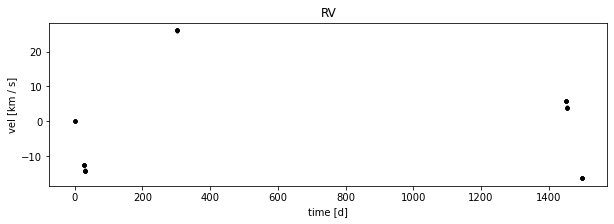

In [14]:
plt.figure(figsize=(10,3))
plt.title('RV')
v_unit = u.km/u.s
plt.plot((times - min(times)).to(u.day).value,bc.to(v_unit).value,'.k')
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

<h2>Loss Function</h2>
Define the loss function from the jabble.loss module. If the errorbars are too bad, use the L2Loss function.

In [15]:
loss = jabble.loss.ChiSquare() #+ jabble.loss.L2Smooth(submodel_ind=[1])

<h2>Create your Jabble Model</h2>
Here we are creating a two part CompositeModel. The first part shifts per epoch, and the second part is a jax linear layer. For the JaxLinear Model you need a set of grid points in x to linearly interpolate into y. So ideally this is set at the resolution or resolutions of the detector. But I guess I could also just use the grid points that were sampled by the detector?

In [16]:
resolution = 35_000
vel_padding = 50 * u.km/u.s

Now we will only be fitting the linear model first, which is at the position 1 in the list in the CompositeModel

In [17]:
x_grid = jabble.model.create_x_grid(wob_data.xs,vel_padding,resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))
stellar_model = jabble.model.CompositeModel([jabble.model.ShiftingModel(init_shifts),jabble.model.JaxLinear(x_grid)])
stellar_model.fit(1)

2021-11-26 21:52:59.862223: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2021-11-26 21:52:59.862242: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


<h2>Fitting Time</h2>
Now it's time to fit the model to the data using our loss function. And setting some maxiter to stop early to prevent any overfitting.

In [18]:
maxiter = 256
res1 = stellar_model.optimize(loss,wob_data,maxiter)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3999     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3999    256    267      1     0     0   3.123D+02   9.779D+03

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [19]:
print(res1)

      fun: array(9779.15136719)
 hess_inv: <3999x3999 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., ..., 0., 0., 0.])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 267
      nit: 256
     njev: 267
   status: 1
  success: False
        x: array([0., 0., 0., ..., 0., 0., 0.])


<h2>Grid Search Velocity Shifts</h2>
Now that we have moderately fit the model to the data. We can try a preliminary velocity grid search. First define the velocities to be searched at each epoch. Simply take the init velocities then outer add using some velocity kernel. Here we decide the step size to be: <br>
$$\Delta v = \frac{c}{R}$$

In [20]:
vel_width = 10 * u.km/u.s
vel_step = const.c/resolution/10.
velocity_kern = np.arange(-vel_width.to(u.km/u.s).value,vel_width.to(u.km/u.s).value,vel_step.to(u.km/u.s).value)*u.km/u.s
velocity_grid = np.add.outer(bc,velocity_kern)

shift_grid = jabble.dataset.shifts(velocity_grid)
loss_array = stellar_model[0].grid_search(shift_grid,loss,stellar_model,wob_data)

In [21]:
print(vel_step)

856.5498799999999 m / s


The grid search returns a loss array of the same size as the velocity grid. Now we take the lowest loss of each epoch on these grids along with it's two neighbors, and create a parabola. The minimum of that parabola is used as the new velocity shift.

In [22]:
x_min, x_vals, y_vals, polynomials = jabble.dataset.get_parabolic_min(loss_array,shift_grid,return_all=True)
stellar_model[0].p = x_min

epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 8
epch 7: min 5
epch 8: min 5
epch 9: min 8
epch 10: min 8
epch 11: min 6
epch 12: min 6
epch 13: min 8
epch 14: min 15
epch 15: min 12
epch 16: min 13
epch 17: min 15
epch 18: min 16
epch 19: min 13
epch 20: min 13
epch 21: min 16
epch 22: min 0
minimum likely out of range
epch 23: min 0
minimum likely out of range
epch 24: min 0
minimum likely out of range
epch 25: min 0
minimum likely out of range
epch 26: min 0
minimum likely out of range
epch 27: min 0
minimum likely out of range
epch 28: min 0
minimum likely out of range
epch 29: min 0
minimum likely out of range
epch 30: min 23
minimum likely out of range
epch 31: min 23
minimum likely out of range
epch 32: min 23
minimum likely out of range
epch 33: min 23
minimum like

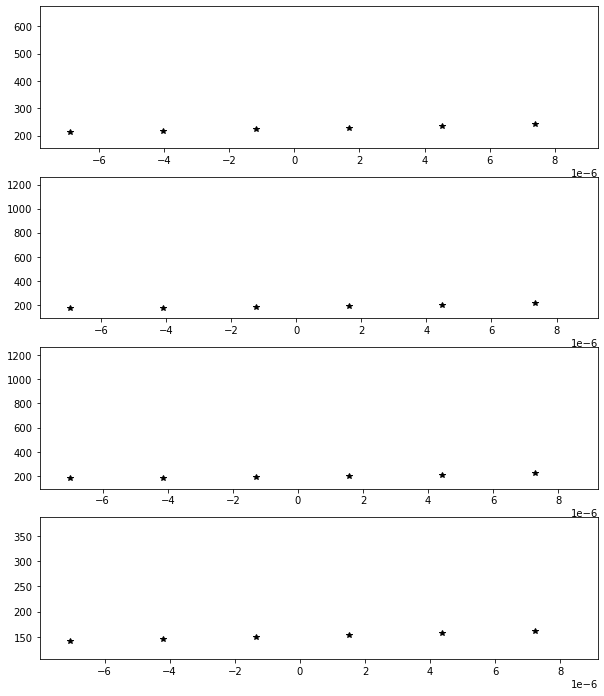

In [23]:
plt_epoch = 4
fig, axes = plt.subplots(plt_epoch,figsize=(10,3 *plt_epoch))
for i in range(plt_epoch):
    axes[i].set_xlim(init_shifts[i]-3*jabble.dataset.shifts(vel_step),init_shifts[i]+3*jabble.dataset.shifts(vel_step))
    axes[i].plot(shift_grid[i,:],loss_array[i,:],'*k')
plt.show()

<h2>Second Round of Fitting</h2>
Now once we have a better velocity estimate, we can fit both the jaxlinear model and the shifting model simultaneously!

In [ ]:
stellar_model.fit(0)
stellar_model.fit(1)
maxiter = 256
res2 = stellar_model.optimize(loss,wob_data,maxiter)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         4051     M =           10


These finals velocities will be compared with the known values from Simulacra.

In [ ]:
final_vels = jabble.dataset.velocityfromshift(stellar_model[0].p)

In [ ]:
plt.figure(figsize=(10,3))
plt.title('EPRV')
v_unit = u.m/u.s

# plt.plot((times - min(times)).to(u.day).value % period.value,(rv-bc).to(v_unit).value,'or',label='truth')
plt.plot((times - min(times)).to(u.day).value % period.value,(final_vels-bc).to(v_unit).value,'ok',label='prediction')

plt.legend()
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()


# plt.ylim(-1,1)